# QBOi Tigramite notebook.

First attempt at a shared jupyter notebook.
- Install Tigramite and dependencies
- Load data from Dropbox
- Run Causal Effect Network analysis on QBOi data

All models are loaded, but currently some have errors in the v_flux timeseries.

Warning: Runtime type must be Python 2 (Python 3 not supported by Tigramite)

## Install dependencies and Tigramite
Use pip install to load cython and ace, then use pip install git+... to load tigramite directly from the github repo.

In [1]:
# Imports required python packages
import numpy
import numpy.ma as ma
import matplotlib
from matplotlib import pyplot as plt
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

import numpy as np
import pandas as pd
import netCDF4
from scipy import signal

%matplotlib inline     

Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package


In [9]:
tigramite


<module 'tigramite' from '/home/tyrrell/anaconda3/envs/py2/lib/python2.7/site-packages/tigramite-3.0b0-py2.7-linux-x86_64.egg/tigramite/__init__.pyc'>

Read data in to Pandas dataframe

In [2]:
ERA = "/home/tyrrell/research/qbo/qboi/cen_data/erai_day.csv"
CAM = "/home/tyrrell/research/qbo/qboi/cen_data/CAM_QBOiExp1_r1i1p1_day.csv"
CCCmaCMAM = "/home/tyrrell/research/qbo/qboi/cen_data/CCCmaCMAM_QBOiExp1_r1i1p1_day.csv"
ISAC_CNRECHAM5sh = "/home/tyrrell/research/qbo/qboi/cen_data/ISAC-CNRECHAM5sh_QBOiExp1_r1i1p1_day.csv"
MIROCMIROC_AGCM = "/home/tyrrell/research/qbo/qboi/cen_data/MIROCMIROC-AGCM_QBOiExp1_r1i1p1_day.csv"
MIROCMIROC_ESM = "/home/tyrrell/research/qbo/qboi/cen_data/MIROCMIROC-ESM_QBOiExp1_r1i1p1_day.csv"
#MOHCUMGA7 = "https://www.dropbox.com/s/vnq57vebl3izq4y/MOHCUMGA7_QBOiExp1_r2i1p1_day.csv?dl=1"
# MRIMRI_ESM2 = ""
WACCM = "/home/tyrrell/research/qbo/qboi/cen_data/WACCM_QBOiExp1_r1i1p1_day.csv"
# YonseiHadGEM2_A = ""
# YonseiHadGEM2_AC = ""

era = pd.read_csv(ERA,index_col=0)
cam = pd.read_csv(CAM,index_col=0)
cccmacmam  = pd.read_csv(CCCmaCMAM,index_col=0)
isac_cnrecham5sh = pd.read_csv(ISAC_CNRECHAM5sh,index_col=0)
mirocmiroc_agcm = pd.read_csv(MIROCMIROC_AGCM,index_col=0)
mirocmiroc_esm = pd.read_csv(MIROCMIROC_ESM,index_col=0)
#mohcumga7 = pd.read_csv(MOHCUMGA7,index_col=0)
#mrimri_esm2 = pd.read_csv(MRIMRI_ESM2,index_col=0)
waccm = pd.read_csv(WACCM,index_col=0)
#yonseihadgem2_a = pd.read_csv(YonseiHadGEM2_A,index_col=0)
#yonseihadgem2_ac = pd.read_csv(YonseiHadGEM2_AC,index_col=0)


### Remove seasonal cycle and detrend, fix sign, time means

In [3]:

def rm_seascyc(df):
    """
    Remove seasonal cycle and detrend data from a pandas dataframe, 
    then return the anomaly dataframe 
    and a Tigramite dataframe
    """

    # Remove time of day from date
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].apply( lambda df : pd.datetime(year=df.year, 
                                                         month=df.month, 
                                                         day=df.day))

    # set date column as index
    df.set_index('date', inplace=True)

    # Create new column of day of year
    df['DoY'] = df.index.dayofyear
    #df['mon'] = df.index.month

    # Get seasonal cycle, (transform keeps array the same size)
    seascyc = df.groupby('DoY').transform('mean')

    # Remove seasonal cycle, create anomaly actors dataframe
    anomact = df - seascyc
    anomact.drop('DoY',axis=1,inplace=True)

    #detrend data
    for colname, col in anomact.iteritems():
        #print(colname)
        anomact[colname] = signal.detrend(anomact[colname],axis=0)  

    #print(anomact.head(n=3))

    # Put data into tigramite dataframe

    var_names=anomact.keys()
    anomact_tdf = pp.DataFrame(anomact.as_matrix(columns=var_names[1::]))

    return anomact, seascyc

# Note: this doesn't work with NaN values
era_anom, era_seascyc = rm_seascyc(era)
cam_anom, cam_seascyc = rm_seascyc(cam)
cccmacmam_anom, cccmacmam_seascyc = rm_seascyc(cccmacmam)
isac_cnrecham5sh_anom, isac_cnrecham5sh_seascyc = rm_seascyc(isac_cnrecham5sh)
mirocmiroc_agcm_anom, mirocmiroc_agcm_seascyc = rm_seascyc(mirocmiroc_agcm)
mirocmiroc_esm_anom, mirocmiroc_esm_seascyc = rm_seascyc(mirocmiroc_esm)
# mohcumga7_anom, mohcumga7_seascyc = rm_seascyc(mohcumga7)
# mrimri_esm2_anom, mrimri_esm2_seascyc = rm_seascyc(mrimri_esm2)
# waccm_anom, waccm_seascyc = rm_seascyc(waccm)
# yonseihadgem2_a_anom, yonseihadgem2_a_seascyc = rm_seascyc(yonseihadgem2_a)
# yonseihadgem2_ac_anom, yonseihadgem2_ac_seascyc = rm_seascyc(yonseihadgem2_ac)

# === reverse sign of NAO, PoV, v_flux ===


for rev_var in ['PoV']:
    #  cam_anom[rev_var] = cam_anom[rev_var]*(-1)
    #  cccmacmam_anom[rev_var] = cccmacmam_anom[rev_var]*(-1)
    isac_cnrecham5sh_anom[rev_var] = isac_cnrecham5sh_anom[rev_var]*(-1)
    #  mirocmiroc_agcm_anom[rev_var] = mirocmiroc_agcm_anom[rev_var]*(-1)
    mirocmiroc_esm_anom[rev_var] = mirocmiroc_esm_anom[rev_var]*(-1)

for rev_var in ['NAO']:
    cam_anom[rev_var] = cam_anom[rev_var]*(-1)
    cccmacmam_anom[rev_var] = cccmacmam_anom[rev_var]*(-1)
#  isac_cnrecham5sh_anom[rev_var] = isac_cnrecham5sh_anom[rev_var]*(-1)
#  mirocmiroc_agcm_anom[rev_var] = mirocmiroc_agcm_anom[rev_var]*(-1)
#  mirocmiroc_esm_anom[rev_var] = mirocmiroc_esm_anom[rev_var]*(-1)

for rev_var in ['v_flux']:
    cam_anom[rev_var] = cam_anom[rev_var]*(-1)
    #  cccmacmam_anom[rev_var] = cccmacmam_anom[rev_var]*(-1)
    isac_cnrecham5sh_anom[rev_var] = isac_cnrecham5sh_anom[rev_var]*(-1)
    #  mirocmiroc_agcm_anom[rev_var] = mirocmiroc_agcm_anom[rev_var]*(-1)
    mirocmiroc_esm_anom[rev_var] = mirocmiroc_esm_anom[rev_var]*(-1)


# === define weekly mean ===

def weekmean(df):
    n=0
    for colname, col in df.iteritems():
        #print(colname)
        #anomact[colname] = signal.detrend(anomact[colname],axis=0)  
        new_series = df[colname].resample('W').mean()
        new_series.name = colname
        if n==0:
            newdf = pd.DataFrame(new_series)
            n=1
        else:
            newdf[colname] = new_series

    return newdf
      
era_week = weekmean(era_anom)
cam_week = weekmean(cam_anom)
cccmacmam_week = weekmean(cccmacmam_anom)
isac_cnrecham5sh_week = weekmean(isac_cnrecham5sh_anom)
mirocmiroc_agcm_week = weekmean(mirocmiroc_agcm_anom)
mirocmiroc_esm_week = weekmean(mirocmiroc_esm_anom)
#mohcumga7_week = weekmean(mohcumga7_anom)

era_abs_week = weekmean(era)
cam_abs_week = weekmean(cam)
cccmacmam_abs_week = weekmean(cccmacmam)
isac_cnrecham5sh_abs_week = weekmean(isac_cnrecham5sh)
mirocmiroc_agcm_abs_week = weekmean(mirocmiroc_agcm)
mirocmiroc_esm_abs_week = weekmean(mirocmiroc_esm)
#mohcumga7_abs_week = weekmean(mohcumga7)



### Create masks for QBOE and QBOW months. Include mask for months ONDJFM

In [5]:
# Mask data for QBOW, and create QBOW and QBOE dataframes

def qbomask(df_abs, df, u_lim=2):
    """
    Take a dataframe (df) with all timeseriees, put QBO into seperate df,
    make masks with the QBO data.
    Uses a threshold of +/- 5 m/s for u-wind, unless otherwise specified.
    Input: dataframe of anomalies
    Output: dataframe w/o QBO, df of QBO, mask for QBOE, mask for QBOW, 
          mask for no qbo, i.e. mask of months ONDJFM
    """

    # Put QBO timeseries in a seperate df and create QBOE/W df
    df_qbo = df_abs[['QBO']].copy() # Use abs values to calc QBO
    df_noqbo = df.drop('QBO',axis=1)

    # Add month series
    df_noqbo['mon'] = df_noqbo.index.month

    # Set up masked arrays
    mask_qbow = np.zeros(df_qbo.shape).astype('bool')
    mask_qboe = np.zeros(df_qbo.shape).astype('bool')
    mask_mon = np.zeros(df_qbo.shape).astype('bool')

    # Create QBOW Mask for given u_lim
    mask_qbow = np.ma.masked_less(df_qbo.as_matrix(columns=['QBO']),u_lim).mask
    # Make mask same size as full df
    df_size = df_noqbo.shape[1]
    mask_qbow2 = np.tile(mask_qbow,df_size)
    # Repeat for QBOE
    mask_qboe = np.ma.masked_greater(df_qbo.as_matrix(columns=['QBO']),-u_lim).mask
    mask_qboe2 = np.tile(mask_qboe,df_size)

    # Create Mask for Months Oct-Mar (i.e. mask out all other months)
    mask_mon[:,0] = (
                    #(df_noqbo['mon'] == 1) | (df_noqbo['mon'] == 2) |
                    #(df_noqbo['mon'] == 3) | 
                    (df_noqbo['mon'] == 4) | (df_noqbo['mon'] == 5) |
                    (df_noqbo['mon'] == 6) | (df_noqbo['mon'] == 7) |
                    (df_noqbo['mon'] == 8) | (df_noqbo['mon'] == 9) |
                    (df_noqbo['mon'] == 10) | (df_noqbo['mon'] == 11) |
                    (df_noqbo['mon'] == 12)
                    ).as_matrix()


    mask_mon2 = np.tile(mask_mon,df_size) #.reshape(mask_qboe2.shape)

    # Add month mask to QBO masks
    mask_qboe_mon = mask_qboe2 + mask_mon2
    mask_qbow_mon = mask_qbow2 + mask_mon2

    # Use QBO masks on data
    #  df_qboe.mask(mask_qboe2,inplace=True)
    #  df_qbow.mask(mask_qbow2,inplace=True)

    return(df_noqbo, df_qbo, mask_qboe_mon, mask_qbow_mon, mask_mon2)

era_noqbo, era_qbo, era_qboe_mask, era_qbow_mask, era_noqbo_mask = qbomask(era_abs_week,era_week)
cam_noqbo, cam_qbo, cam_qboe_mask, cam_qbow_mask, cam_noqbo_mask = qbomask(cam_abs_week,cam_week)
cccmacmam_noqbo, cccmacmam_qbo, cccmacmam_qboe_mask, cccmacmam_qbow_mask, cccmacmam_noqbo_mask = qbomask(cccmacmam_abs_week,cccmacmam_week)
isac_cnrecham5sh_noqbo, isac_cnrecham5sh_qbo, isac_cnrecham5sh_qboe_mask, isac_cnrecham5sh_qbow_mask, isac_cnrecham5sh_noqbo_mask = qbomask(isac_cnrecham5sh_abs_week,isac_cnrecham5sh_week)
mirocmiroc_agcm_noqbo, mirocmiroc_agcm_qbo, mirocmiroc_agcm_qboe_mask, mirocmiroc_agcm_qbow_mask, mirocmiroc_agcm_noqbo_mask = qbomask(mirocmiroc_agcm_abs_week,mirocmiroc_agcm_week)
mirocmiroc_esm_noqbo, mirocmiroc_esm_qbo, mirocmiroc_esm_qboe_mask, mirocmiroc_esm_qbow_mask, mirocmiroc_esm_noqbo_mask = qbomask(mirocmiroc_esm_abs_week,mirocmiroc_esm_week)



## Plotting

### Plot all models

#### Function for plotting

-----------------------------------------------------
CAM
['PoV', 'v_flux']
All years


AttributeError: PCMCI instance has no attribute 'return_significant_parents'

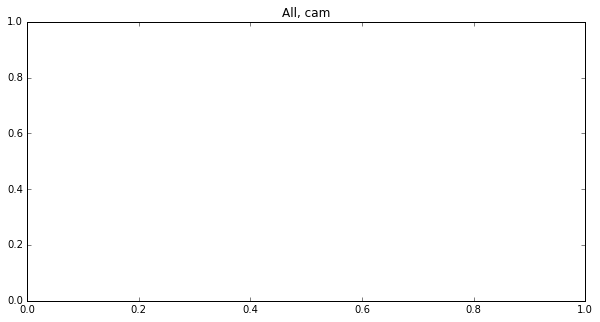

In [7]:

def run_and_plot(dataframe, cond_ind_test, fig_ax, var_select):
    """
    small function from example notebook to calc pcmci and plot masked links
    
    """
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    results = pcmci.run_pcmci(tau_min=0,tau_max=2,pc_alpha=0.4)
    link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=0.4)['link_matrix']
    tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
                  link_matrix=link_matrix, var_names=var_select,
    )
    return

def plot_model(df_noqbo,mon_mask,qboe_mask,qbow_mask,var_select,mask_type=None,
               save_plot=False,save_name=None,save_qbo=False,title=None):
               #var_names=['AO','BK-tas','EA-tas','PoV','Sib-SLP','Ural-SLP',
               #           'v_flux']):
    """
    Function to plot three link matrices, for all years, qboe and qbow, for selected
    variables
    Input:
    df_noqbo  = pandas dataframe of timeseries (without qbo)
    mon_mask  = masked array of months ONDJFM
    qboe_mask = masked array of QBOE, same dimensions as data
    qbow_mask = masked array of QBOW, same dimensions as data
    var_names = list of variables for link matrix
    mask_type = masking mode, 'y','x','z','yz','xy','xz','xyz', if None,'y' used
    save_name = name to save plot, if None then not saved

    """
    print(var_select)
    df_names=df_noqbo[var_select]
    n_cols = len(var_select)

    tig_df_all = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=mon_mask[:,0:n_cols])
    tig_df_qboe = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=qboe_mask[:,0:n_cols])
    tig_df_qbow = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=qbow_mask[:,0:n_cols])

    # Causal graph all QBO years
    print("All years")
    fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111); plt.title("All, {}".format(title))
    run_and_plot(tig_df_all, ParCorr(significance='analytic', mask_type=mask_type), (fig, ax), var_select=var_select)
    # nt 21/02/2019 Removed use_mask=True, because update to code causes this to crash, see
    # https://github.com/jakobrunge/tigramite/commit/27d5f3789093164bec86d74ce04cb3a6ec0e7f1c#diff-e773bbc3398ad209273b9db59e379c17
    # old code below
    # run_and_plot(tig_df_all, ParCorr(significance='analytic',use_mask=True, mask_type=mask_type), (fig, ax), var_select=var_select)

    current_var = "_".join(var_select)
    if save_plot:
        plt.savefig('{}_all_day_{}.png'.format(save_name,current_var), bbox_inches='tight')

    """
    # # Causal graph, QBOE
    print("QBOE years")
    fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111);  plt.title("QBOE, {}".format(title))
    run_and_plot(tig_df_qboe, ParCorr(significance='analytic',use_mask=True, mask_type=mask_type), (fig, ax), var_select=var_select)

    if save_plot and save_qbo:
    fig.savefig('{}_qboe_day_{}.png'.format(save_name,current_var), bbox_inches='tight')
    figfile = drive.CreateFile({'title':'{}_qboe_day_{}.png'.format(save_name,current_var),
                                'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
    figfile.SetContentFile('{}_qboe_day_{}.png'.format(save_name,current_var))
    figfile.Upload()  

    # # Causal graph, QBOW
    print("QBOW years")
    fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111);  plt.title("QBOW, {}".format(title))
    run_and_plot(tig_df_qbow, ParCorr(significance='analytic',use_mask=True, mask_type=mask_type), (fig, ax), var_select=var_select)

    if save_plot and save_qbo:
    fig.savefig('{}_qbow_day_{}.png'.format(save_name,current_var), bbox_inches='tight')
    figfile = drive.CreateFile({'title':'{}_qbow_day_{}.png'.format(save_name,current_var),
                                'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
    figfile.SetContentFile('{}_qbow_day_{}.png'.format(save_name,current_var))
    figfile.Upload()
    """
    return

# All available variable names:
# var_names=['NAO','BK-tas','EA-tas','PoV','Sib-SLP','Ural-SLP','v_flux']

save_plot=False #True # set to True/False to save the plots to drive folder

# var_select=['NAO','PoV','v_flux']

var_select=['NAO','BK-SIC','EA-tas','PoV','Sib-SLP','Ural-SLP','v_flux']
var_select=['PoV','v_flux'] #,'PoV','v_flux']
#var_select=['PoV','v_flux']


print("-----------------------------------------------------")
print("ERA")
plot_model(era_noqbo,era_noqbo_mask,era_qboe_mask,era_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="era", title="era")
print("-----------------------------------------------------")
print("CAM")
plot_model(cam_noqbo,cam_noqbo_mask,cam_qboe_mask,cam_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="cam", title="cam")
print("-----------------------------------------------------")
print("CCCMA")
plot_model(cccmacmam_noqbo,cccmacmam_noqbo_mask,cccmacmam_qboe_mask,cccmacmam_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="cccmacmam",title="cccmacmam")
print("-----------------------------------------------------")
print("ISAC")
plot_model(isac_cnrecham5sh_noqbo,isac_cnrecham5sh_noqbo_mask,isac_cnrecham5sh_qboe_mask,isac_cnrecham5sh_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="isac_cnrecham5sh",title="isac_cnrecham5sh")
#print("-----------------------------------------------------")
#print("MIROC AGCM")
#plot_model(mirocmiroc_agcm_noqbo,mirocmiroc_agcm_noqbo_mask,mirocmiroc_agcm_qboe_mask,mirocmiroc_agcm_qbow_mask,
#          var_select=var_select,save_plot=save_plot,save_name="mirocmiroc_agcm",title="mirocmiroc_agcm")
print("-----------------------------------------------------")
print("MIROC ESM")
plot_model(mirocmiroc_esm_noqbo,mirocmiroc_esm_noqbo_mask,mirocmiroc_esm_qboe_mask,mirocmiroc_esm_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mirocmiroc_esm",title="mirocmiroc_esm")
print("-----------------------------------------------------")
"""
print("MOHC")
plot_model(mohcumga7_noqbo,mohcumga7_noqbo_mask,mohcumga7_qboe_mask,mohcumga7_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mohcumga7",title="mohcumga7")
print("-----------------------------------------------------")
print("MRI")
plot_model(mrimri_esm2_noqbo,mrimri_esm2_noqbo_mask,mrimri_esm2_qboe_mask,mrimri_esm2_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mrimri_esm2",title="mrimri_esm2")
print("-----------------------------------------------------")
print("WACCM")
plot_model(waccm_noqbo,waccm_noqbo_mask,waccm_qboe_mask,waccm_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="waccm",title="waccm")
print("-----------------------------------------------------")
print("YONSEI A")
plot_model(yonseihadgem2_a_noqbo,yonseihadgem2_a_noqbo_mask,yonseihadgem2_a_qboe_mask,yonseihadgem2_a_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="yonseihadgem2_a",title="yonseihadgem2_a")
print("-----------------------------------------------------")
print("YONSEI AC")
plot_model(yonseihadgem2_ac_noqbo,yonseihadgem2_ac_noqbo_mask,yonseihadgem2_ac_qboe_mask,yonseihadgem2_ac_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="yonseihadgem2_ac",title="yonseihadgem2_ac")
"""

### Ensemble mean plots


The code  below calculates the link matrices for all models, then combines them. You can change the models used by changing the "mods" list. Change the actors used by changing the var_select list. Rerun the two cells below to see the changes.



In [10]:
# Function for ensemble plots


def run_and_plot_prepare_ensemble(dataframe, cond_ind_test, var_select, tau_max,
                                  tau_min, pc_alpha=0.1):
    """
    small function from example notebook to calc pcmci and plot masked links
    
    """
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test) #, var_names=var_select)
    results = pcmci.run_pcmci(tau_min=tau_min,tau_max=tau_max,pc_alpha=pc_alpha)
    link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=pc_alpha)['link_matrix']
# #     tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
# #                   link_matrix=link_matrix, var_names=var_select,
#     )
    return results, link_matrix




In [11]:
### WORKING QBOE/W MASK
### 

mods = [cam_noqbo,cccmacmam_noqbo,isac_cnrecham5sh_noqbo,
        mirocmiroc_esm_noqbo]
        #mirocmiroc_agcm_noqbo,
        #,mohcumga7_noqbo]
        #,mrimri_esm2_noqbo,waccm_noqbo,
        #yonseihadgem2_a_noqbo,yonseihadgem2_ac_noqbo]

qemask = [cam_qboe_mask, cccmacmam_qboe_mask, isac_cnrecham5sh_qboe_mask, 
        mirocmiroc_esm_qboe_mask]
        # mirocmiroc_agcm_qboe_mask,
        #,mohcumga7_qboe_mask]
        #,mrimri_esm2_qboe_mask,waccm_qboe_mask,
        #yonseihadgem2_a_qboe_mask,yonseihadgem2_ac_qboe_mask]
qwmask = [cam_qbow_mask, cccmacmam_qbow_mask, isac_cnrecham5sh_qbow_mask,
        mirocmiroc_esm_qbow_mask]
        # mirocmiroc_agcm_qbow_mask,
        #,mohcumga7_qbow_mask]
        #,mrimri_esm2_qbow_mask,waccm_qbow_mask,
        #yonseihadgem2_a_qbow_mask,yonseihadgem2_ac_qbow_mask]
monmask = [cam_noqbo_mask, cccmacmam_noqbo_mask, isac_cnrecham5sh_noqbo_mask, 
        mirocmiroc_esm_noqbo_mask]
        #mirocmiroc_agcm_noqbo_mask,
        #,mohcumga7_noqbo_mask]
        #,mrimri_esm2_noqbo_mask,waccm_noqbo_mask,
        #yonseihadgem2_a_noqbo_mask,yonseihadgem2_ac_noqbo_mask]

# var_select=['EA-tas','BK-tas','Sib-SLP','Ural-SLP'] #,'EA-tas']
var_select=['NAO','BK-SIC','EA-tas','PoV','Sib-SLP','Ural-SLP'] # ['BK-tas','EA-tas','PoV','v_flux','Sib-SLP']
#var_select=['NAO','PoV','BK-SIC']
var_select=['v_flux','Sib-SLP','EA-tas','PoV']

current_var = "_".join(var_select)
print("Current variables: {}".format(current_var))

# Change these variables
tau_max = 5         # Maximum lag
tau_min = 1         # Minimum lag
robust_thres = .4   #Only show links that are significant in that fraction of models
alpha_level = 0.3

n_models = len(mods)
n_cols = len(var_select)

link_matrices_all = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_all = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
link_matrices_qe = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_qe = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
link_matrices_qw = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_qw = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))

for i in range(n_models):
    print(i)
    # Initialize dataframe object
    data = mods[i].as_matrix(columns=var_select)
    
    df_all = pp.DataFrame(data,mask=monmask[i][:,0:n_cols])
    df_qbow = pp.DataFrame(data, mask=qwmask[i][:,0:n_cols])
    df_qboe = pp.DataFrame(data, mask=qemask[i][:,0:n_cols])
    
    print('results all')
    results_all, link_matrix_all = run_and_plot_prepare_ensemble(df_all, 
                                      ParCorr(significance='analytic',mask_type='y'),
                                      var_select=var_select, tau_max=tau_max,
                                      tau_min=tau_min,pc_alpha=alpha_level)
    print('results qboe')
    results_qboe, link_matrix_qboe = run_and_plot_prepare_ensemble(df_qboe,
                                      ParCorr(significance='analytic',mask_type='y'),
                                      var_select=var_select, tau_max=tau_max,
                                      tau_min=tau_min,pc_alpha=alpha_level)
    results_qbow, link_matrix_qbow = run_and_plot_prepare_ensemble(df_qbow,
                                      ParCorr(significance='analytic',mask_type='y'),
                                      var_select=var_select, tau_max=tau_max,
                                      tau_min=tau_min,pc_alpha=alpha_level)

    link_matrices_all[i] = link_matrix_all
    average_vals_all[i] = results_all['val_matrix']
    link_matrices_qw[i] = link_matrix_qbow
    average_vals_qw[i] = results_qbow['val_matrix']
    link_matrices_qe[i] = link_matrix_qboe
    average_vals_qe[i] = results_qboe['val_matrix']


print("ALL YEARS")
link_color_matrix_all = average_vals_all.mean(axis=0)
link_width_all = link_matrices_all.mean(axis=0)
link_matrix_all = link_width_all > robust_thres

print("QBOW YEARS")
link_color_matrix_qw = average_vals_qw.mean(axis=0)
link_width_qw = link_matrices_qw.mean(axis=0)
link_matrix_qw = link_width_qw > robust_thres

print("QBOE YEARS")
link_color_matrix_qe = average_vals_qe.mean(axis=0)
link_width_qe = link_matrices_qe.mean(axis=0)
link_matrix_qe = link_width_qe > robust_thres




## PLOT ENSEMBLE PLOTS

# FIGURE PROPERTIES

savefig = False #True # False # Save figures in the google drive, True or False

vmax_edges=0.7; vmin_edges=-0.7
vmax_nodes=0.7; vmin_nodes=0.0
edge_ticks=0.2; node_ticks=0.2
cmap_nodes='YlOrBr'; cmap_edges='RdBu_r'
    

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111,frameon=False)
plt.title("MMM, All, week")
print("ALL YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_all,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_all,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_all,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges,
    node_size=30,
    node_label_size=20,
    arrowhead_size=20,
    arrow_linewidth=30,
    show_colorbar=True
    )

if savefig:
    plt.savefig('modens_week_{}.png'.format(current_var), bbox_inches='tight')


Current variables: v_flux_Sib-SLP_EA-tas_PoV
0
results all


AttributeError: PCMCI instance has no attribute 'return_significant_parents'

QBOW YEARS


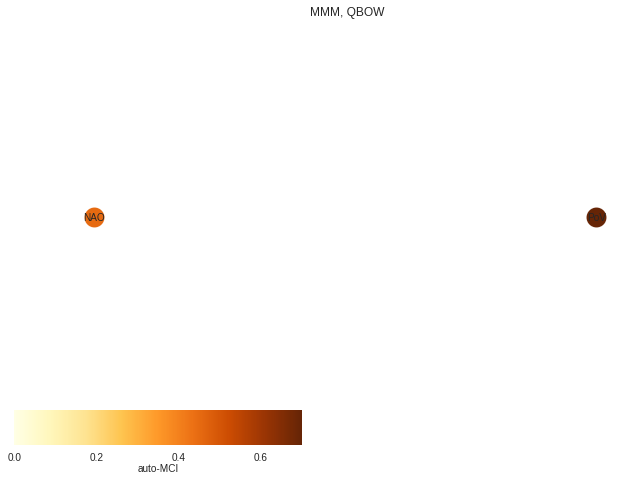

In [24]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOW")
print("QBOW YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qw,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_qw,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qe,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges
    )

if savefig:
    plt.savefig('modens_week_qbow_{}.png'.format(current_var), bbox_inches='tight')
    

QBOE YEARS


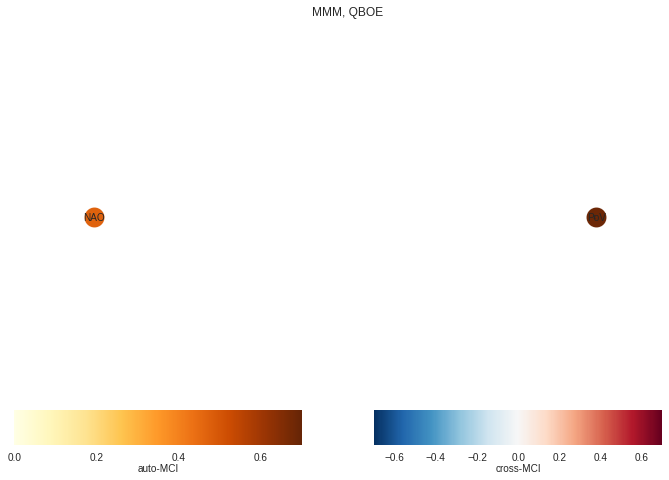

In [10]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOE")
print("QBOE YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qe,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_qe,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qe,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges
    )

if savefig:
    plt.savefig('modens_week_qboe_{}.png'.format(current_var), bbox_inches='tight')
    


QBOE - QBOW


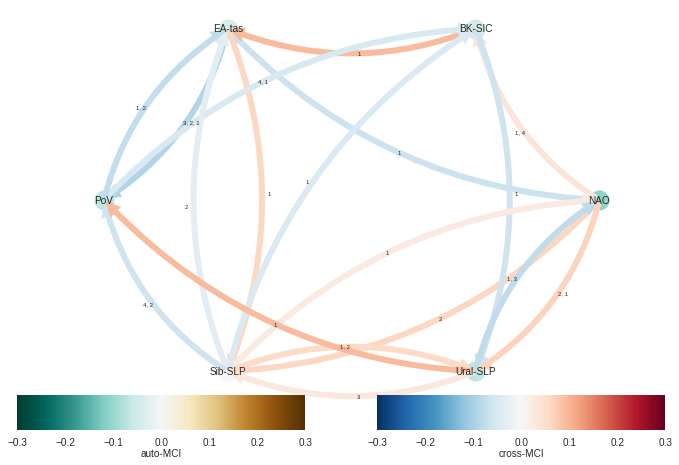

In [0]:
## PLOT ENSEMBLE PLOTS for difference between QBOE-QBOW
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111,frameon=False)

link_color_matrix_diff = link_color_matrix_qe - link_color_matrix_qw
link_matrix_diff = link_matrix_qe ^ link_matrix_qw
link_width_diff = np.abs(link_width_qe - link_width_qw)

fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
print("QBOE - QBOW")
tp.plot_graph(
    val_matrix=link_color_matrix_diff,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_diff,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmax_edges=0.3,
    vmin_edges=-0.3,
    edge_ticks=0.1,
    node_ticks=0.1,
    vmax_nodes=0.3,
    vmin_nodes=-0.3,
    cmap_nodes='BrBG_r',
    cmap_edges='RdBu_r'
    )
if savefig:
    plt.savefig('modens_week_qbodif_{}.png'.format(current_var), bbox_inches='tight')



ALL YEARS
QBOW YEARS
QBOE YEARS
QBO DIFF: QBOE - QBOW


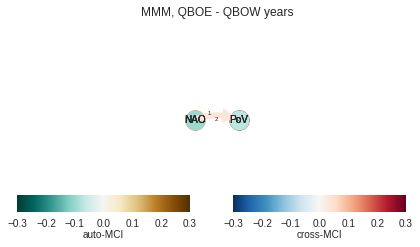

In [0]:
####### NOTE - new version of Tigramite is doing something screwy to the figures, individual figs work - Nick 03/2019
## PLOT ENSEMBLE PLOTS

# FIGURE PROPERTIES

savefig = False # Save figures in the google drive, True or False

vmax_edges=0.7; vmin_edges=-0.7
vmax_nodes=0.7; vmin_nodes=0.0
edge_ticks=0.2; node_ticks=0.2
cmap_nodes='YlOrBr'; cmap_edges='RdBu_r'
    

fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, All")
print("ALL YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_all,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_all,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_all,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges
    )

if savefig:
    plt.savefig('ens_week_all_{}.png'.format(current_var), bbox_inches='tight')


fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOW")
print("QBOW YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qw,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_qw,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qw,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges
    )

if savefig:
    plt.savefig('ens_week_qbo_w_{}.png'.format(current_var), bbox_inches='tight')


fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOE")
print("QBOE YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qe,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_qe,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qe,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges
    )

if savefig:
    plt.savefig('ens_week_qbo_e_{}.png'.format(current_var), bbox_inches='tight')

## PLOT ENSEMBLE PLOTS for difference between QBOE-QBOW
fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)

link_color_matrix_diff = link_color_matrix_qe - link_color_matrix_qw
link_matrix_diff = link_matrix_qe ^ link_matrix_qw
link_width_diff = np.abs(link_width_qe - link_width_qw)

fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOE - QBOW years")
print("QBO DIFF: QBOE - QBOW")
tp.plot_graph(
    val_matrix=link_color_matrix_diff,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_diff,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmax_edges=0.3,
    vmin_edges=-0.3,
    edge_ticks=0.1,
    node_ticks=0.1,
    vmax_nodes=0.3,
    vmin_nodes=-0.3,
    cmap_nodes='BrBG_r',
    cmap_edges='RdBu_r'
    )

if savefig:
    plt.savefig('ens_week_qbo_diff_{}.png'.format(current_var), bbox_inches='tight')

In [0]:
print(link_color_matrix_qe)
print(link_color_matrix_qw)

[[[ 0.          0.68852305 -0.1661944   0.01891326  0.02932729]
  [ 0.00759075  0.00363316  0.04238395  0.01858568 -0.01005559]]

 [[ 0.00759075  0.02790492  0.01113722  0.01358088 -0.02807837]
  [ 0.          0.47283311 -0.03542194  0.00993412 -0.01269796]]]
[[[ 0.00000000e+00  7.16976657e-01 -2.29792284e-01  8.73189554e-02
    2.05361906e-02]
  [ 2.31646169e-02 -1.46979620e-02  3.18540941e-02  1.71427711e-02
   -2.75231808e-02]]

 [[ 2.31646169e-02 -1.15785799e-02  2.39527268e-02  4.38028859e-04
   -2.53993909e-02]
  [ 0.00000000e+00  4.37102120e-01  5.94253803e-02 -1.05964620e-02
    2.73757615e-02]]]


In the code below I attempted to plot three plots on one figure. Passed the fig and ax to plotting function, but doesn't behave how I'd expect - Nick

In [0]:
## PLOT ENSEMBLE PLOTS
fig = plt.figure(figsize=(20,5))

#fig = plt.gcf()
ax1 = fig.add_subplot(1,3,1, frameon=False) # should have 1 row, with 3 columns
#ax1 = plt.gca()
#print("ALL YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_all,
    fig_ax=(fig,ax1),
    link_matrix=link_matrix_all,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_all,
    show_colorbar=False
    )


#fig = plt.gcf()
ax2 = fig.add_subplot(1,3,2, frameon=False)
ax2 = plt.gca()
#print("QBOW YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qw,
    fig_ax=(fig,ax2),
    link_matrix=link_matrix_qw,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qw,
    show_colorbar=False
    )

#fig = plt.gcf()
ax3 = fig.add_subplot(1,3,3, frameon=False)
ax3 = plt.gca()
#print("QBOE YEARS")

out = tp.plot_graph(
    val_matrix=link_color_matrix_qe,
    fig_ax=(fig,ax3),
    link_matrix=link_matrix_qe,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qe,
    show_colorbar=True
    )


#print(type(out))
#print(type(fig))
#fig.savefig('ens_qbo_e.png', bbox_inches='tight')
#figfile = drive.CreateFile({'title':'ens_qbo_e.png',
#                            'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
#figfile.SetContentFile('ens_qbo_e.png')
#figfile.Upload()

In [0]:
#Example to save a figure to file
#it will be save in the personal downloads so still need to upload it back to the drive
#import matplotlib.pyplot as plt
#from google.colab import files
#fig = plt.figure()
#ax = fig.add_axes([1,1,1,1])
#plt.plot([1,2])
#plt.savefig('abc.png', bbox_inches='tight')
#files.download("abc.png") 